In [120]:
# Library
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan

import warnings
warnings.simplefilter('ignore')
import seaborn as sns

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
    
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

---
## Data
Quarterly(1993Q2-2024Q4)
### Output gap
Beveridge-Nelson Filter's cycle component (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### The number of Firm  
Business Employment Dynamics (https://db.nomics.world/BLS/bd?tab=list)

---

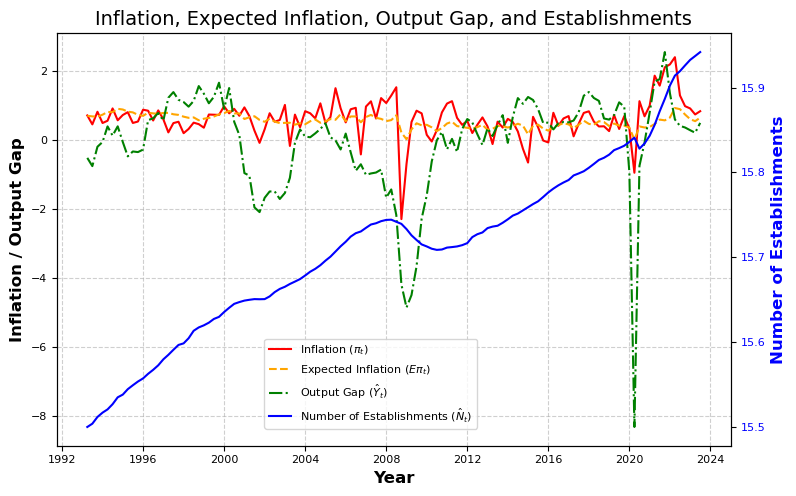

In [121]:
# Data cleaning and plot
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_N = pd.merge(data_Nb, data_Nd, on = "DATE")
data_N = data_N.dropna()
data_N["Nchange"] = data_N["Nb"] - data_N["Nd"]
data_N = data_N[data_N["DATE"] >= "1993-04-01"]
initial_value = 5387024
data_N["N"] = initial_value + data_N["Nchange"].shift(fill_value=0).cumsum()
data_N["N"] = np.log(data_N["N"])
# data_N.to_csv("data/N.csv", index=False)

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])
data_N['DATE'] = pd.to_datetime(data_N['DATE'])

data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")

data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data = data.dropna()
data = data[["DATE","pi", "Epi", "Y", "N", "pi_prev", "Y_prev"]]

# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
Y = jnp.array(data['Y'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Y_prev = jnp.array(data['Y_prev'],dtype=jnp.float64)

data_N_hat = pd.read_csv("data/BN_filter_user_inputted_series_results.csv")
data_N_hat["cycle"] = data_N_hat["cycle"]
N_hat = jnp.array(data_N_hat["cycle"],dtype=jnp.float64)


# plot
# --- two-axis version with legend outside ---
fig, ax1 = plt.subplots(figsize=(8, 5))

# left axis
ax1.plot(data["DATE"], data["pi"],  label=r'Inflation $(\pi_{t})$',              color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$',   linestyle='--', color='orange')
ax1.plot(data["DATE"], data["Y"],   label=r'Output Gap $(\hat{Y}_{t})$',        linestyle='-.', color='green')
ax1.set_xlabel('Year',  fontsize=12, weight='bold')
ax1.set_ylabel('Inflation / Output Gap', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# right axis
ax2 = ax1.twinx()
ax2.plot(data["DATE"], data["N"],   label=r'Number of Establishments $(\hat{N}_{t})$', color='blue')
ax2.set_ylabel('Number of Establishments', fontsize=12, weight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# legend outside (right side)
lines  = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels,
           loc='center left',          # anchor to the left-center of bbox
           bbox_to_anchor=(0.3, 0.15), # push legend just outside the axes
           frameon=True, fontsize=8)

ax1.set_title('Inflation, Expected Inflation, Output Gap, and Establishments', fontsize=14)
fig.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [122]:
warmup= 500
samples=1500
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

# Model
- Note: $\alpha$ + $\beta$ = 1
- Model 0 : NKPC 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t
$$
- Model 1 : HSA NKPC 
 - observation equation
$$
    \pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t
$$
$$N_{t}=\bar{N}_t+\hat{N}_t$$

 - state equation
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}}  + \eta_t
$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + u_t$$
$$\hat{N}_t = \alpha_1 \hat{N}_{{t-1}} + v_t$$

$$
\epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

$\pi_{t}$ : Inflation rate = ($\frac{\text{CPI}_{t} - \text{CPI}_{t-1}}{\text{CPI}_{t-1}}$)

$E_t[\hat{\pi}_{t+1}]$ : Quarterly Infration Expectation = $\frac{\text{one year inflation expectation}}{4}$

$\hat{Y}_t$ : Output gap = 100 * cycle of the Real Gross Domestic Product (GDPC1) in US (from BN filter)

$N_{t}$ : the number of establishments = log of (the number of establishments in US * 0.01)

In [123]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "beta"       : dist.Beta(0.5, 0.5),
        "kappa"      : dist.Beta(0.5, 0.5),
        "sigma_eps"  : dist.LogNormal(0,1),   # NKPC error
    }
    return priors

In [124]:
# Model 0

def model_0(pi, pi_prev, pi_expect, Y):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    # model
    pi_pred = alpha * pi_prev + beta * pi_expect + kappa * Y
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi)

# RUN MCMC
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_kappa = posterior_samples["kappa"].mean()
model_0_alpha = posterior_samples["alpha"].mean()
model_0_beta = posterior_samples["beta"].mean()
diverging  = idata_0.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                           # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")            # bool for each param

sample: 100%|██████████| 2000/2000 [00:00<00:00, 6853.05it/s, 15 steps of size 1.73e-01. acc. prob=1.00]


divergence ratio = 0.0000%


In [125]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "beta"       : dist.Beta(0.5, 0.5),
        "kappa"      : dist.Beta(0.5, 0.5),
        # State equation (z) params
        "theta_z"    : dist.Normal(0, 0.5),
        "theta_pi"   : dist.Normal(0, 0.5),
        "theta_N"    : dist.Normal(0, 0.5),
        "theta_Y"    : dist.Normal(0, 0.5), 
        # State equation (N) params
        "bar_n"      : dist.Normal(0, 0.5),  # Nbar trend
        "alpha_1"    : dist.Uniform(-1, 1),  # Nhat AR1 coeff
        # initial
        "z_init"     : dist.Normal(0, 0.5), # z init
        "kappa_init" : dist.Normal(0, 0.5), # kappa init
        # Sigma
        "sigma_eps"  : dist.LogNormal(0,1),   # NKPC error
        "sigma_eta"  : dist.LogNormal(0,1),   # z error
        "sigma_e"    : dist.LogNormal(0,1), # N error
        "sigma_u"    : dist.LogNormal(0,1),   # Nbar error
        "sigma_v"    : dist.LogNormal(0,0.5)  # Nhat error
    }
    return priors

In [126]:
# Model 1
# AR 1
def model_1(pi, pi_prev, pi_expect, Y, Y_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])

    # State equation (z) coefficients
    theta_N = numpyro.sample("theta_N", priors["theta_N"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])

    # State equation (N) params
    bar_n    = numpyro.sample("bar_n", priors["bar_n"])      # drift
    alpha_1  = numpyro.sample("alpha_1", priors["alpha_1"])  # cycle AR(1) coefficient
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 0.1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.01))    # Nhat init
    # Sigma
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      # trend error
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      # cycle error
    sigma_e  = numpyro.sample("sigma_e", priors["sigma_e"])      # N error
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) # pi error
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"]) # z error
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        Nbar_prev = carry[1]
        Nhat_prev = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(bar_n + Nbar_prev, sigma_u))
        # cycle：AR(1)
        Nhat_t  = numpyro.sample("Nhat", dist.Normal(alpha_1 * Nhat_prev, sigma_v))
        # z
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_N * Nhat_t + theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        # observation equation
        # pi
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        # N (Nbar + Nhat = observed N)
        numpyro.sample("N_t", numpyro.distributions.Normal(Nbar_t + Nhat_t, sigma_e), obs=N[t])
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t = t + 1
        return [z, Nbar_t, Nhat_t, t], None
    scan(transition, [z_init, bar_N_0, hat_N_0, t], timesteps)

# RUN MCMC
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,N=N, l=len(pi))
idata_1 = az.from_numpyro(mcmc)

# results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std_1 = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.97 * z_std_1
z_upper_1 = z_mean_1 + 1.97 * z_std_1  

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1 = np.mean(N_bar_samples, axis=0) 
N_bar_std_1 = np.std(N_bar_samples, axis=0)  
N_bar_lower_1 = N_bar_mean_1 - 1.97 * N_bar_std_1
N_bar_upper_1 = N_bar_mean_1 + 1.97 * N_bar_std_1
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1 = np.mean(N_hat_samples, axis=0) 
N_hat_std_1 = np.std(N_hat_samples, axis=0)  
N_hat_lower_1 = N_hat_mean_1 - 1.97 * N_hat_std_1
N_hat_upper_1 = N_hat_mean_1 + 1.97 * N_hat_std_1

model_1_alpha = posterior_samples["alpha"].mean()
model_1_kappa = posterior_samples["kappa"].mean()
model_1_beta = posterior_samples["beta"].mean()
model_1_theta_z = posterior_samples["theta_z"].mean()
model_1_theta_Y = posterior_samples["theta_Y"].mean()
model_1_theta_pi = posterior_samples["theta_pi"].mean()
model_1_theta_N = posterior_samples["theta_N"].mean()
model_1_alpha_1 = posterior_samples["alpha_1"].mean()
model_1_bar_n = posterior_samples["bar_n"].mean()

diverging  = idata_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")


sample: 100%|██████████| 2000/2000 [00:21<00:00, 94.85it/s, 1023 steps of size 4.07e-03. acc. prob=0.94]


divergence ratio = 0.0000%


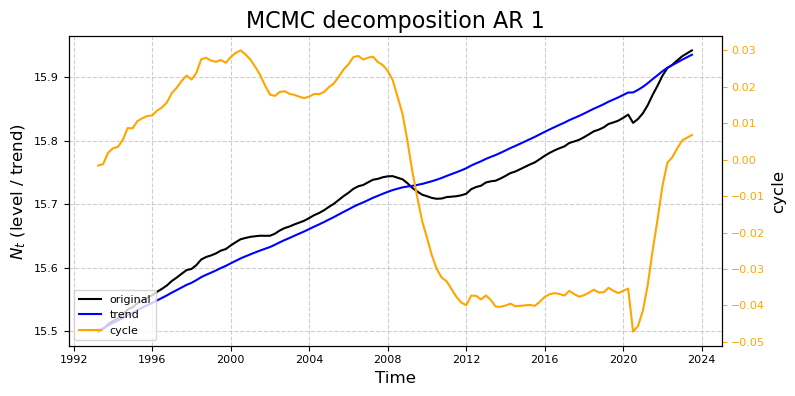

In [127]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# ―― trend ―――――――――――――――――――――――――――
ax1.plot(data["DATE"], N,
         label="original", color=colors[0], lw=1.5)
ax1.plot(data["DATE"], N_bar_mean_1,
         label="trend",    color=colors[1], lw=1.5)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel(r"$N_t$ (level / trend)", fontsize=12)

# ―― cycle ――――――――――――――――――――――――――――――――――――
ax2 = ax1.twinx()
ax2.plot(data["DATE"], N_hat_mean_1,
         label="cycle",  color=colors[2], lw=1.5)
ax2.set_ylabel("cycle", fontsize=12)
ax2.tick_params(axis="y", colors=colors[2]) 

# ―― legend ――――――――――――――――――――――――
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="lower left", fontsize=8, frameon=True)

ax1.set_title("MCMC decomposition AR 1", fontsize=16)
ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [128]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "beta"       : dist.Beta(0.5, 0.5),
        "kappa"      : dist.Beta(0.5, 0.5),
        # State equation (z) params
        "theta_z"    : dist.Normal(0, 0.5),
        "theta_pi"   : dist.Normal(0, 0.5),
        "theta_N"    : dist.Normal(0, 0.5),
        "theta_Y"    : dist.Normal(0, 0.5), 
        # State equation (N) params
        "bar_n"      : dist.Normal(0, 0.5),  # Nbar trend
        # initial
        "z_init"     : dist.Normal(0, 0.5), # z init
        "kappa_init" : dist.Normal(0, 0.5), # kappa init
        # Sigma
        "sigma_eps"  : dist.LogNormal(0,1),   # NKPC error
        "sigma_eta"  : dist.LogNormal(0,1),   # z error
        "sigma_e"    : dist.LogNormal(0,1),   # z error
        "sigma_u"    : dist.LogNormal(0,1),   # Nbar error
        "sigma_v"    : dist.LogNormal(0,0.5)  # Nhat error
    }
    return priors

In [129]:
# Model 2
def model_2(pi, pi_prev, pi_expect, Y, Y_prev, N, l):
    priors = set_prior_distributions()

    # --- NKPC ---
    beta  = numpyro.sample("beta",  priors["beta"])
    alpha = 1.0 - beta
    numpyro.deterministic("alpha", alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])

    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y  = numpyro.sample("theta_Y",  priors["theta_Y"])

    # --- N trend / cycle ---
    bar_n   = numpyro.sample("bar_n", priors["bar_n"])
    rho = numpyro.sample("rho", dist.Beta(2, 2))  # [0, 1], stable
    phi = numpyro.sample("phi", dist.Beta(2, 2))  # [0, 1], periodic

    alpha_1 = 2 * rho * jnp.cos(jnp.pi * phi)
    alpha_2 = -rho ** 2

    numpyro.deterministic("alpha_1", alpha_1)
    numpyro.deterministic("alpha_2", alpha_2)

    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 0.1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.005))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 0.005))   # t=-1
    z_init   = numpyro.sample("z_init", priors["z_init"])

    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_e  = numpyro.sample("sigma_e",  priors["sigma_e"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])

    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, hat_prev1, hat_prev2, t = carry
        # --- trend ---
        bar_N_t = numpyro.sample("bar_N", dist.Normal(bar_prev + bar_n, sigma_u))
        # --- cycle (AR2) ---
        mean_hat = alpha_1 * hat_prev1 + alpha_2 * hat_prev2
        hat_N_t  = numpyro.sample("hat_N", dist.Normal(mean_hat, sigma_v))
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * hat_N_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_Y * Y_prev[t],
                        sigma_eta)
        )
        # --- observation equation ---
        numpyro.sample("N_obs", dist.Normal(bar_N_t + hat_N_t, sigma_e), obs=N[t])
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_eps), obs=pi[t])
        return (z_t, bar_N_t, hat_N_t, hat_prev1, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, 0), timesteps)

# RUN MCMC
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,N=N, l=len(pi))
idata_2 = az.from_numpyro(mcmc)

# results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std_2 = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.97 * z_std_2
z_upper_2 = z_mean_2 + 1.97 * z_std_2  

N_bar_samples = posterior_samples["bar_N"]
N_bar_mean_2 = np.mean(N_bar_samples, axis=0) 
N_bar_std_2 = np.std(N_bar_samples, axis=0)  
N_bar_lower_2 = N_bar_mean_2 - 1.97 * N_bar_std_2
N_bar_upper_2 = N_bar_mean_2 + 1.97 * N_bar_std_2
N_hat_samples = posterior_samples["hat_N"]
N_hat_mean_2 = np.mean(N_hat_samples, axis=0) 
N_hat_std_2 = np.std(N_hat_samples, axis=0)  
N_hat_lower_2 = N_hat_mean_2 - 1.97 * N_hat_std_2
N_hat_upper_2 = N_hat_mean_2 + 1.97 * N_hat_std_2

model_2_alpha = posterior_samples["alpha"].mean()
model_2_kappa = posterior_samples["kappa"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_theta_z = posterior_samples["theta_z"].mean()
model_2_theta_Y = posterior_samples["theta_Y"].mean()
model_2_theta_pi = posterior_samples["theta_pi"].mean()
model_2_theta_N = posterior_samples["theta_N"].mean()
modek_2_alpha_1 = posterior_samples["alpha_1"].mean()
modek_2_alpha_2 = posterior_samples["alpha_2"].mean()
model_2_bar_n = posterior_samples["bar_n"].mean()

diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")


sample: 100%|██████████| 2000/2000 [00:23<00:00, 84.18it/s, 1023 steps of size 1.41e-06. acc. prob=0.99]


divergence ratio = 0.0000%


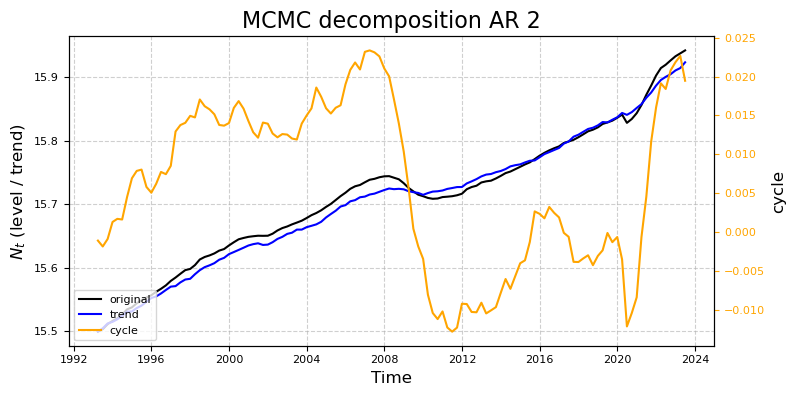

In [130]:
fig, ax1 = plt.subplots(figsize=(8, 4))
# ―― trend ―――――――――――――――――――――――――――
ax1.plot(data["DATE"], N,
         label="original", color=colors[0], lw=1.5)
ax1.plot(data["DATE"], N_bar_mean_2,
         label="trend",    color=colors[1], lw=1.5)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel(r"$N_t$ (level / trend)", fontsize=12)

# ―― cycle ――――――――――――――――――――――――――――――――――――
ax2 = ax1.twinx()
ax2.plot(data["DATE"], N_hat_mean_2,
         label="cycle",  color=colors[2], lw=1.5)
ax2.set_ylabel("cycle", fontsize=12)
ax2.tick_params(axis="y", colors=colors[2]) 

# ―― legend ――――――――――――――――――――――――
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="lower left", fontsize=8, frameon=True)

ax1.set_title("MCMC decomposition AR 2", fontsize=16)
ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Model 3: BN filter before MCMC

In [131]:
# Model 3
def model_3(pi, pi_prev, pi_expect, Y, Y_prev, N_hat, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # State equation (z) params
    theta_N = numpyro.sample("theta_N", priors["theta_N"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        t = carry[1]
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_N * N_hat[t] + theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        z_carry = z
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        return [z_carry, t_carry], None
    scan(transition, [z_init, t], timesteps)


# RUN MCMC
kernel = NUTS(model_3, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, N_hat=N_hat, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std_3 = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.97 * z_std_3
z_upper_3 = z_mean_3 + 1.97 * z_std_3  

model_3_alpha = posterior_samples["alpha"].mean()
model_3_kappa = posterior_samples["kappa"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_theta_z = posterior_samples["theta_z"].mean()
model_3_theta_Y = posterior_samples["theta_Y"].mean()
model_3_theta_pi = posterior_samples["theta_pi"].mean()
model_3_theta_n = posterior_samples["theta_N"].mean()
diverging  = idata_3.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1351.86it/s, 127 steps of size 4.36e-02. acc. prob=0.99]


divergence ratio = 0.0000%


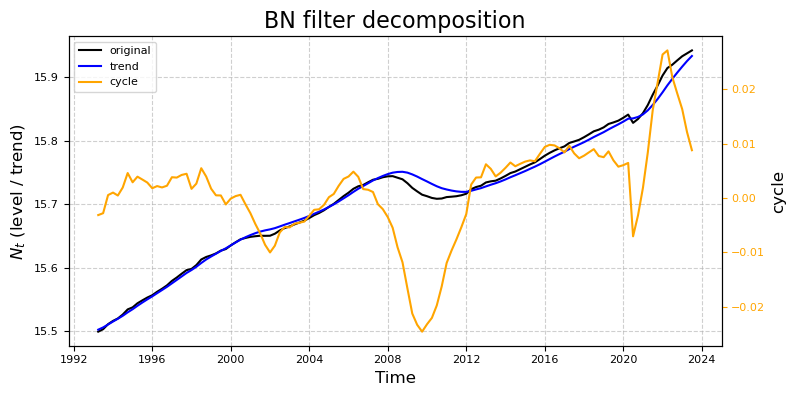

In [132]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# ―― trend ―――――――――――――――――――――――――――
ax1.plot(data["DATE"], data_N_hat["original_series"],
         label="original", color=colors[0], lw=1.5)
ax1.plot(data["DATE"], data_N_hat["trend"],
         label="trend",    color=colors[1], lw=1.5)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel(r"$N_t$ (level / trend)", fontsize=12)

# ―― cycle ――――――――――――――――――――――――――――――――――――
ax2 = ax1.twinx()
ax2.plot(data["DATE"], data_N_hat["cycle"],
         label="cycle",  color=colors[2], lw=1.5)
# ax2.plot(data["DATE"], N_hat_mean_2,
#          label="cycle model 2",  color=colors[3], lw=1.5)
ax2.set_ylabel("cycle", fontsize=12)
ax2.tick_params(axis="y", colors=colors[2]) 

# ―― legend ――――――――――――――――――――――――
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=8, frameon=True)

ax1.set_title("BN filter decomposition", fontsize=16)
ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

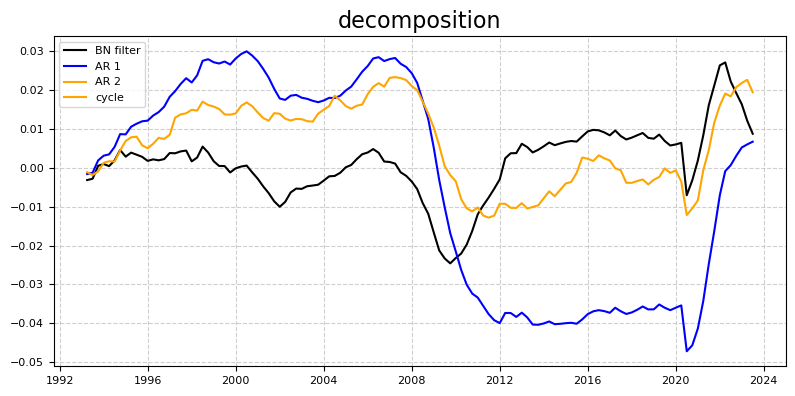

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# ―― cycle ――――――――――――――――――――――――――――――――――――
ax1.plot(data["DATE"], data_N_hat["cycle"],
         label="BN filter",  color=colors[0])
ax1.plot(data["DATE"], N_hat_mean_1,
         label="AR 1",  color=colors[1])
ax1.plot(data["DATE"], N_hat_mean_2,
         label="AR 2",  color=colors[2])
# ax2.plot(data["DATE"], N_hat_mean_2,
#          label="cycle model 2",  color=colors[3], lw=1.5)
ax1.set_ylabel("cycle", fontsize=12)

# ―― legend ――――――――――――――――――――――――
lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=8, frameon=True)
ax1.set_title("decomposition", fontsize=16)
ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [133]:
dict_idata = {'Normal NKPC':idata_0, 'HSA NKPC (AR1)':idata_1,'HSA NKPC (AR2)':idata_2,'HSA NKPC (BN filter)':idata_3}
params = ["alpha","beta", "kappa", "theta_z", "theta_Y", "theta_pi", "theta_N",'bar_n', 'alpha_1', "alpha_2", "sigma_eps", "sigma_eta"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,beta,kappa,theta_z,theta_Y,theta_pi,theta_N,bar_n,alpha_1,alpha_2,sigma_eps,sigma_eta
0,Normal NKPC,0.205,0.795,0.082,-,-,-,-,-,-,-,0.479,-
1,HSA NKPC (AR1),0.029,0.971,0.143,0.407,0.058,-0.030,0.123,0.004,0.989,-,0.203,0.379
2,HSA NKPC (AR2),0.042,0.958,0.172,0.673,0.053,-0.020,-0.012,0.003,1.030,-0.344,0.381,0.186
3,HSA NKPC (BN filter),0.047,0.953,0.156,0.409,0.065,-0.043,-0.094,-,-,-,0.286,0.322


In [134]:
var = pd.DataFrame({
    "Variable": ["π", "Yhat", "Nhat", "E[πₜ₊₁]"],
    "Variance": [
        np.var(pi),
        np.var(Y),
        np.var(N_hat),
        np.var(pi_expect)
    ]
})
display(var)

z_data = pd.DataFrame()
z_data["DATE"] = data["DATE"]
z_data["z_mean_2"] = z_mean_1
z_var = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Variance of Z": [
        np.var(z_mean_1),
        np.var(z_mean_2),
        np.var(z_mean_3),
    ]
})
display(z_var)



coeff = pd.DataFrame({
    "Variable": [
        "Cov(N, Y)"    
    ],
    "Correlation": [    
        np.corrcoef(data["N"], data["Y"])[0, 1]
    ]
})
display(coeff)


coeff_zY = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Cov(z, Y)": [    
        np.corrcoef(z_mean_1, data["Y"])[0, 1],
        np.corrcoef(z_mean_2, data["Y"])[0, 1],
        np.corrcoef(z_mean_3, data["Y"])[0, 1]
    ]
})
display(coeff_zY)

coeff_zN = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Cov(z, N)": [    
        np.corrcoef(z_mean_1, data["N"])[0, 1],
        np.corrcoef(z_mean_2, data["N"])[0, 1],
        np.corrcoef(z_mean_3, data["N"])[0, 1]
    ]
})
display(coeff_zN)


,Variable,Variance
0,π,0.31586352
1,Yhat,2.0901945
2,Nhat,8.2692546e-05
3,E[πₜ₊₁],0.031964805


,Model,Variance of Z
0,Model 1,0.14576422
1,Model 2,0.114362255
2,Model 3,0.100994535


,Variable,Correlation
0,"Cov(N, Y)",0.040482


,Model,"Cov(z, Y)"
0,Model 1,0.169000
1,Model 2,0.455365
2,Model 3,0.271670


,Model,"Cov(z, N)"
0,Model 1,-0.361503
1,Model 2,-0.406821
2,Model 3,-0.363976


In [135]:
# az.plot_posterior(idata_3, var_names=["alpha", "beta", "kappa", "theta_n", "theta_z", "theta_Y", "theta_pi"])

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

,elpd_waic,p_waic
HSA NKPC (AR1),-28.557274,102.719666
HSA NKPC (BN filter),-60.662655,73.507545
HSA NKPC (AR2),-63.757721,18.986376
Normal NKPC,-88.526430,10.452709


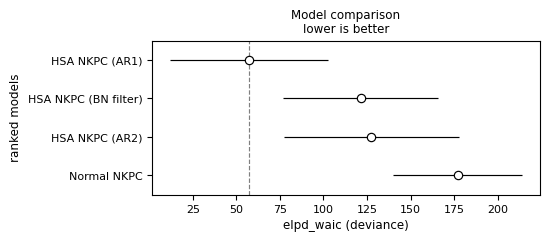

In [136]:
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(5, 2))

cmp = az.compare(dict_idata, var_name="pi_obs" , ic='waic', scale=None)  # ← deviance でなく純 elpd
display(cmp[['elpd_waic','p_waic']])

# In-sample Fit

In [137]:
# tables = {
#     "posterior_means"   : summary_df,
#     "variance_core"     : var,
#     "variance_z"        : z_var,
#     "corr_NY"           : coeff,
#     "corr_zY"           : coeff_zY,
#     "corr_zN"           : coeff_zN,
#     "loo_compare_dev"   : df_loo_dev
# }

# for name, df in tables.items():
#     latex_code = df.to_latex(index=False, escape=False)
#     display(Markdown(f"### {name}\n```latex\n{latex_code}\n```"))

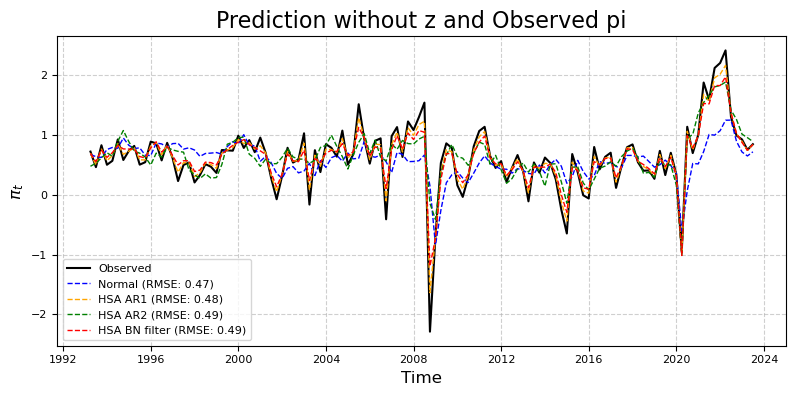

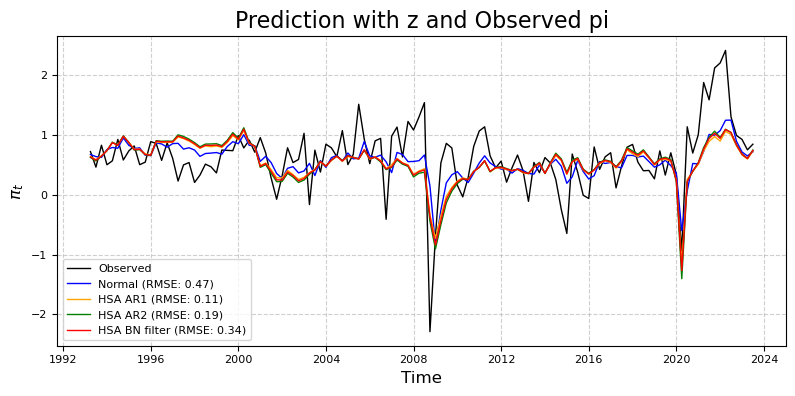

In [138]:
pi_pred_0 = model_0_alpha * data["pi_prev"] + model_0_beta * data["Epi"] + model_0_kappa * data["Y"]
pi_pred_1 = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"]
pi_pred_2 = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"]
pi_pred_3 = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"]

pi_pred_1_z = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"] - z_mean_1
pi_pred_2_z = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"] - z_mean_2
pi_pred_3_z = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"] - z_mean_3

obs = data["pi"]

def get_scores(y_true, y_pred):
    e = y_true - y_pred
    rmse = np.sqrt(np.mean(e ** 2))
    mae = np.mean(np.abs(e))
    return rmse, mae

scores = {
    "Model 0": get_scores(obs, pi_pred_0),
    "Model 1": get_scores(obs, pi_pred_1),
    "Model 2": get_scores(obs, pi_pred_2),
    "Model 3": get_scores(obs, pi_pred_3)
    }

# plot
title = "Prediction without z and Observed pi"
plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1.5)
plt.plot(data["DATE"], pi_pred_0, label=f"Normal (RMSE: {scores['Model 0'][0]:.2f})", 
         color=colors[1], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_1_z, label=f"HSA AR1 (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[2], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_2_z, label=f"HSA AR2 (RMSE: {scores['Model 2'][0]:.2f})",
         color=colors[3], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_3_z , label=f"HSA BN filter (RMSE: {scores['Model 3'][0]:.2f})",
         color=colors[4], linestyle='--', linewidth=1)

plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


scores = {
    "Model 0": get_scores(obs, pi_pred_0),
    "Model 1": get_scores(obs, pi_pred_1_z),
    "Model 2": get_scores(obs, pi_pred_2_z),
    "Model 3": get_scores(obs, pi_pred_3_z),

    }

plt.figure(figsize=(8, 4))
title = "Prediction with z and Observed pi"
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_0, label=f"Normal (RMSE: {scores['Model 0'][0]:.2f})", 
         color=colors[1], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_1, label=f"HSA AR1 (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[2], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_2, label=f"HSA AR2 (RMSE: {scores['Model 3'][0]:.2f})",
         color=colors[3], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_3, label=f"HSA BN filter (RMSE: {scores['Model 2'][0]:.2f})",
         color=colors[4], linestyle='-', linewidth=1)

plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Z

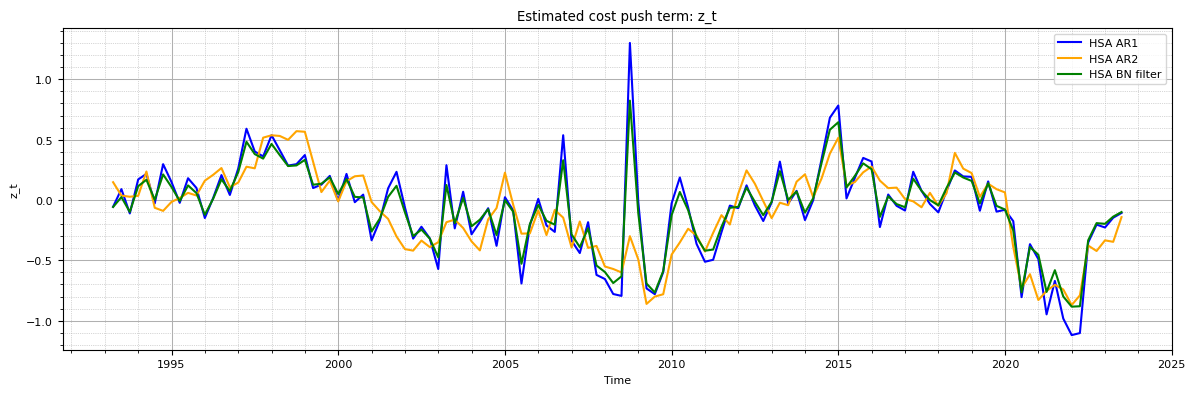

In [139]:
plt.rcParams.update({'font.size': 8}) 
import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_1, label="HSA AR1", color=colors[1])
# plt.fill_between(data["DATE"], z_lower_1, z_upper_1, color=colors[1], alpha=0.2, label="95% Credible Interval")
plt.plot(data["DATE"], z_mean_2, label="HSA AR2", color=colors[2])
# plt.fill_between(data["DATE"], z_lower_2, z_upper_2, color=colors[2], alpha=0.2, label="95% Credible Interval")
plt.plot(data["DATE"], z_mean_3, label="HSA BN filter", color=colors[3])
plt.title("Estimated cost push term: z_t")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()
